# Overview - Max Pain Theory


The Maximum Pain theory states that an option's price will gravitate towards a max pain price, in some cases equal to the strike price for an option, that causes the maximum number of options to expire worthless.

## Calculating the Max Pain Point


For each in-the-money strike price for both puts and calls:

1.Find the difference between stock price and strike price
    2.Multiply the result by open interest at that strike
    3.Add together the dollar value for the put and call at that strike
    4.Repeat for each strike price
    Find the highest value strike price. This price is equivalent to max pain price.

In [1]:
import pandas as pd
import yfinance as yf
import datetime
import matplotlib.pyplot as plt

In [3]:
## Get's the option chain for a given symbol and expiry date and add it to panda df

def options_chain(tk, expiry):
    '''
    Get's the option chain for a given symbol and expiry date and add it to panda df
    Credit: https://medium.com/@txlian13/webscrapping-options-data-with-python-and-yfinance-e4deb0124613
    '''
    # Get options exp
    options = pd.DataFrame()
    opt = tk.option_chain(expiry.strip())
    opt = pd.DataFrame().append(opt.calls).append(opt.puts)
    opt['expirationDate'] = expiry
    options = options.append(opt, ignore_index=True)
    
    # Add 1 day to get the correct expiration date
    options['expirationDate'] = pd.to_datetime(options['expirationDate']) + datetime.timedelta(days = 1)
    options['dte'] = (options['expirationDate'] - datetime.datetime.today()).dt.days / 365
    
    # Boolean column if the option is a CALL
    options['CALL'] = options['contractSymbol'].str[4:].apply(
        lambda x: "C" in x)
    
    options[['bid', 'ask', 'strike']] = options[['bid', 'ask', 'strike']].apply(pd.to_numeric)
    
    # Drop unnecessary and meaningless columns
    options = options.drop(columns = ['contractSize', 'currency', 'change', 'percentChange', 'lastTradeDate', 'lastPrice', 'contractSymbol', 'bid', 'ask', 'impliedVolatility', 'inTheMoney', 'dte'])
    
    return options


In [4]:
def total_loss_on_strike(chain, expiry_price):
    '''
    Get's the total loss at the given strike price
    '''    
    # call options with strike price below the expiry price -> loss for option writers
    callChain = chain.loc[chain['CALL'] == True]
    callChain = callChain.dropna()       
    in_money_calls = callChain[callChain['strike'] < expiry_price][["openInterest", "strike"]]
    in_money_calls["CLoss"] = (expiry_price - in_money_calls['strike'])*in_money_calls["openInterest"]

    # get puts n drop null values
    putChain = chain.loc[chain['CALL'] == False]
    putChain = putChain.dropna()    
    
    # put options with strike price above the expiry price -> loss for option writers
    in_money_puts = putChain[putChain['strike'] > expiry_price][["openInterest", "strike"]]
    in_money_puts["PLoss"] = (in_money_puts['strike'] - expiry_price)*in_money_puts["openInterest"]
    total_loss = in_money_calls["CLoss"].sum() + in_money_puts["PLoss"].sum()

    return total_loss

In [5]:
def getInput():
    '''
    gets the user input on symbol and expiry
    '''
    symbol = input("Enter the Symbol: " )
    
    tk = yf.Ticker(symbol)
    # Expiration dates
    exps = tk.options   
    print("Expiry dates:")        
    for i in exps:
        print(f"{i}", end=", ")
  
    
    expiry = input("\nEnter the Expiry data [format: YYYY-MM-DD]: " )
    return tk, expiry, symbol


Enter the Symbol: AAPL
Expiry dates:
2022-06-10, 2022-06-17, 2022-06-24, 2022-07-01, 2022-07-08, 2022-07-15, 2022-07-22, 2022-08-19, 2022-09-16, 2022-10-21, 2022-11-18, 2022-12-16, 2023-01-20, 2023-03-17, 2023-06-16, 2023-09-15, 2024-01-19, 2024-06-21, 
Enter the Expiry data [format: YYYY-MM-DD]: 2022-06-10
Maximum Pain: 142.59 < 147.0 < 151.41
Put to call ratio: 0.64


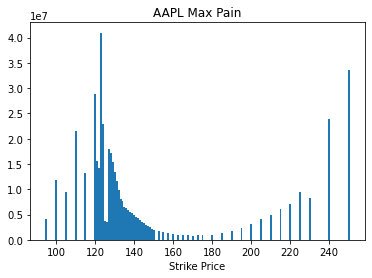

In [6]:
def main():
    '''
    Get's the symbol and expiry date n plot the data
    '''
    # gets the user input on symbol and expiry
    tk, expiry, symbol = getInput()
    chain = options_chain(tk, expiry)
    
    strikes = chain.get(['strike']).values.tolist()
    losses = [total_loss_on_strike(chain, strike[0]) for strike in strikes] 
    
    # max pain min loss to option writers/sellers at strike price
    flat_strikes = [item for sublist in strikes for item in sublist]
    point = losses.index(min(losses))
    max_pain = flat_strikes[point]
    buffer = 3
    bufferHigh = max_pain + (max_pain * (buffer/100))
    bufferLow = max_pain - (max_pain * (buffer/100))
    print(f"Maximum Pain: {bufferLow} < {max_pain} < {bufferHigh}")
    
    # calc put to call ratio
    callChain = chain.loc[chain['CALL'] == True]
    putChain = chain.loc[chain['CALL'] == False]
    pcr = putChain["volume"].sum() / callChain["volume"].sum()
    print("Put to call ratio:", round(pcr,2))
    
    # get the cummulated losses
    total = {}
    for i in range(len(flat_strikes)):
        if flat_strikes[i] not in total: total[flat_strikes[i]] = losses[i]
        else: total[flat_strikes[i]] += losses[i]
            
    
    # plot
    keys = set(list(total.keys()))
    plt.bar(list(keys), list(total.values()), width=1)
    plt.xlabel('Strike Price')
    plt.title(f'{symbol.upper()} Max Pain')    


if __name__ == "__main__":
    main()